In [82]:
import pandas as pd
import numpy as np
from boto3 import Session
import awswrangler as wr
import seaborn as sns
import matplotlib.pyplot as plt
import acessos as ac
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [2]:
amostra = ac.df_athena_q('flavia-costa', 'select * from research_curated_zone.monitoramento_modelo_perfis')

In [3]:
len(amostra)

6972

In [4]:
amostra['dt_pesquisa'].value_counts()

2022-11-01    2653
2023-02-01    2254
2022-08-01    2065
Name: dt_pesquisa, dtype: int64

In [5]:
amostra['cpf'] = amostra['cpf'].str.replace('"', '')
amostra['cpf'] = amostra['cpf'].astype('int')

In [6]:
amostra.head()

,dt_pesquisa,cd_yearmonth,cpf,id_pesquisa,barrado,compartilhador,multiplicador,acumulador,acumulador_score,barrado_score,multiplicador_score
0,2023-02-01,2023-02,20346542774,344,0,1,1,0,0.285136,0.548963,0.277846
1,2022-11-01,2022-11,2257916336,2370,1,1,0,0,0.285505,0.547121,0.397491
2,2022-11-01,2022-11,5405388173,326,0,0,1,0,0.432475,0.109783,0.792224
3,2022-11-01,2022-11,15351509474,1937,1,1,1,0,0.306657,0.459133,0.878999
4,2023-02-01,2023-02,11814590447,1853,0,0,1,0,0.394406,0.185959,0.810835


In [7]:
amostra['mes'] = amostra['dt_pesquisa']

In [8]:
amostra = amostra.query('acumulador_score > 0')

In [9]:
len(amostra)

6728

In [10]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import regularizers

2023-07-28 17:40:55.107979: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 17:40:55.351741: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 17:40:55.352727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 17:40:56.883654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
non_comp = amostra[amostra['compartilhador'] == 0]
compart = amostra[amostra['compartilhador'] == 1]

df = non_comp.append(compart).sample(frac=1).reset_index(drop=True)
X = amostra[['acumulador_score', 'barrado_score', 'multiplicador_score']].values
Y = amostra["compartilhador"].values



/tmp/ipykernel_1676736/3389877700.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_comp.append(compart).sample(frac=1).reset_index(drop=True)


In [19]:
## input layer
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh')(input_layer)
encoded = Dropout(0.25)(encoded)
encoded = Dense(10, activation='tanh')(encoded)

## decoding part
decoded = Dense(10, activation='tanh')(encoded)
decoded = Dropout(0.25)(decoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [20]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_5 (Dense)             (None, 100)               400       
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_8 (Dense)             (None, 100)               1100

In [15]:
from sklearn import preprocessing

In [21]:
x_scale = preprocessing.MinMaxScaler().fit_transform(X)
x_non_comp, x_compart = x_scale[Y == 0], x_scale[Y == 1]

In [22]:
autoencoder.fit(x_non_comp, x_non_comp,
                batch_size = 256, epochs = 30,
                shuffle = True, validation_split = 0.20);

Epoch 1/30
13/13 [==============================] - 1s 22ms/step - loss: 0.1198 - val_loss: 0.0419
Epoch 2/30
13/13 [==============================] - 0s 7ms/step - loss: 0.0491 - val_loss: 0.0181
Epoch 3/30
13/13 [==============================] - 0s 7ms/step - loss: 0.0275 - val_loss: 0.0059
Epoch 4/30
13/13 [==============================] - 0s 7ms/step - loss: 0.0194 - val_loss: 0.0042
Epoch 5/30
13/13 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0031
Epoch 6/30
13/13 [==============================] - 0s 8ms/step - loss: 0.0142 - val_loss: 0.0030
Epoch 7/30
13/13 [==============================] - 0s 7ms/step - loss: 0.0126 - val_loss: 0.0025
Epoch 8/30
13/13 [==============================] - 0s 8ms/step - loss: 0.0113 - val_loss: 0.0023
Epoch 9/30
13/13 [==============================] - 0s 11ms/step - loss: 0.0105 - val_loss: 0.0022
Epoch 10/30
13/13 [==============================] - 0s 11ms/step - loss: 0.0094 - val_loss: 0.0021
Epoch 11/30
13/1

In [24]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_5 (Dense)             (None, 100)               400       
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_8 (Dense)             (None, 100)               1100

In [23]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])#entrada
hidden_representation.add(autoencoder.layers[1])#dense 100
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])#dense 50

In [25]:
non_comp_hid_rep = hidden_representation.predict(x_non_comp)
compart_hid_rep = hidden_representation.predict(x_compart)

83/83 [==============================] - 0s 1ms/step


In [29]:
rep_x = np.append(non_comp_hid_rep, compart_hid_rep, axis = 0)
y_n = np.zeros(non_comp_hid_rep.shape[0])
y_f = np.ones(compart_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [30]:
tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(rep_x)
apoio_graf = pd.DataFrame(X_t)
apoio_graf['label'] = rep_y
apoio_graf.columns = ['pca1', 'pca2', 'label']

/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


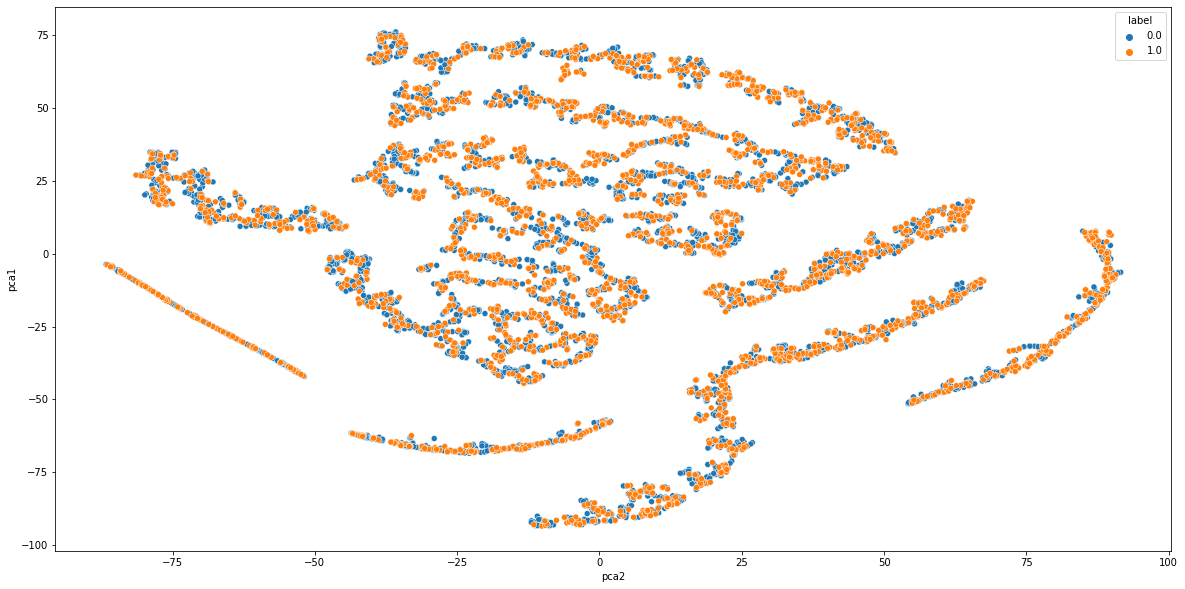

In [78]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = apoio_graf, x = 'pca2', y = 'pca1',  hue = 'label')
plt.show()

In [83]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76      1030
         1.0       0.00      0.00      0.00       652

    accuracy                           0.61      1682
   macro avg       0.31      0.50      0.38      1682
weighted avg       0.37      0.61      0.47      1682


Accuracy Score:  0.6123662306777645


/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
from sklearn.svm import SVC
from sklearn import metrics
svm_clf = SVC()
svm_clf.fit(train_x, train_y)
y_predicted_svm = svm_clf.predict(val_x)
accuracy_svm = metrics.accuracy_score(val_y, y_predicted_svm).round(3)
print(accuracy_svm)

0.612
